In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_curve,
                             roc_auc_score)
import warnings
warnings.filterwarnings('ignore')
#from sklearn import set_config
#set_config(transform_output="pandas")

In [2]:
def churn_data_load():
  df = pd.read_csv('/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
  #print (df)

  # Convert TotalCharges column data into numeric type
  # Using 'coerce' option to convert invalid values to NaN
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

  # Drop rows that have NaN
  df.dropna(inplace = True)
  #print (df)

  # Separate features and label
  # customerID will have no effect on the model prediction
  # We can remove it. Since, the model is trying to predict
  # Churn, we will remove Churn from features as well
  X = df.drop(['Churn', 'customerID'], axis = 1)

  # Map the Churn column data into numerical values
  y = df['Churn'].map({'Yes': 1, 'No': 0})

  return X, y

In [3]:
def create_new_features(X):
  # Average Monthly Charge
  X['AvgMonthlyCharge'] = X['TotalCharges']/X['tenure']
  # Handle division by zero
  X['AvgMonthlyCharge'] = X['AvgMonthlyCharge'].replace([np.inf, -np.inf], 0)

  # Multiple Line Indicator
  X['MultipleLinesIndicator'] = X['MultipleLines'].apply(lambda x: 1 if x in ['Yes'] else 0)

  # Online Security Indicator
  X['OnlineSecurityIndicator'] = X['OnlineSecurity'].apply(lambda x: 1 if x in ['Yes'] else 0)

  # Tech Support Indicator
  X['TechSupportIndicator'] = X['TechSupport'].apply(lambda x: 1 if x in ['Yes'] else 0)

  # Streaming Movies Indicator
  X['StreamingMoviesIndicator'] = X['StreamingMovies'].apply(lambda x: 1 if x in ['Yes'] else 0)

  # Combined Service Count
  X["ServiceCount"] = X[[
        "OnlineSecurity", "OnlineBackup", "DeviceProtection",
        "TechSupport", "StreamingTV", "StreamingMovies"
    ]].apply(lambda row: row.isin(["Yes"]).sum(), axis=1)

  # High Speed Internet Indicator
  X['HighSpeedInternet'] = X['InternetService'].apply(lambda x: 1 if x == "Fiber optic" else 0)

  # Contract Length in Months
  contract_mapping = {"Month-to-month": 1, "One year": 12, "Two year": 24}
  X["ContractMonths"] = X["Contract"].map(contract_mapping)

  # Tenure and Contract Interaction
  X["TenureContractInteraction"] = X["tenure"] * X["ContractMonths"]

  # Total Charges per Contract Month
  X["TotalChargePerContractMonth"] = X["TotalCharges"] / X["ContractMonths"]
  X["TotalChargePerContractMonth"] = X["TotalChargePerContractMonth"].replace([np.inf, -np.inf], 0) # Handle division by zero

  # Online vs Offline contract
  X["OnlineContract"] = X["PaymentMethod"].apply(lambda x: 1 if "Electronic" in x else 0)

  # Price per Service
  X['PricePerService'] = X['TotalCharges'] / (X['ServiceCount'] * X['tenure'])
  X['PricePerService'] = X['PricePerService'].replace([np.inf, -np.inf], 0) # Handle division by zero

  # Monthly Charge Change - Let's assume no change if tenure is 1
  X['PrevMonthlyCharge'] = (X['TotalCharges'] - X['MonthlyCharges']) / (X['tenure'] - 1)
  X['PrevMonthlyCharge'] = X['PrevMonthlyCharge'].replace([np.inf, -np.inf], 0)
  X['MonthlyChargeChange'] = X['MonthlyCharges'] - X['PrevMonthlyCharge']

  return X


In [4]:
def data_prep(X, y):

  # Add the new features
  X = create_new_features(X)

  # Identify numerical and categorical columns
  num_ftrs = X.select_dtypes(include = ['int64', 'float64']).columns
  ctg_ftrs = X.select_dtypes(include = ['object']).columns

  #print (num_ftrs)
  #print (ctg_ftrs)
  # Data preprocessing steps numerical and categorical features
  num_trnsfrmr = Pipeline(steps = [
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
      ])
  ctg_trnsfrmr = Pipeline(steps = [
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
      ])

  monthly_change_pipeline = Pipeline([
      ('imputer', SimpleImputer(strategy = 'median')),
      ('robust', RobustScaler())
      ])

  # Apply the data transformations
  pre_prcsr = ColumnTransformer(transformers=[
      ('num', num_trnsfrmr, num_ftrs),
      ('ctg', ctg_trnsfrmr, ctg_ftrs),
      ('monthly', monthly_change_pipeline, ['MonthlyChargeChange'])
      ])

  # Split the data into train & test sets
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y)

  return X_train, X_test, y_train, y_test, pre_prcsr



In [5]:
def train_model(X_train, y_train, pre_prcsr):
  # Create a pipeline with pre_prcsr and logistic regression model
  model = Pipeline(steps = [
      ('preprcsr', pre_prcsr),
      ('classifier', LogisticRegression(
          max_iter=1000, class_weight='balanced'))
      ])

  # Fit the model
  model.fit(X_train, y_train)

  return model

In [6]:
def train_model_hyp_prmtr_tuning(X_train, y_train, pre_prcsr):
  # Create a pipeline with pre_prcsr and logistic regression model
  model = Pipeline(steps=[
      ('preprcsr', pre_prcsr),
      ('classifier', LogisticRegression(
          max_iter=1000, class_weight='balanced'))
      ])

  # Define the parameter grid for GridSearchCV
  prmtr_grid = [
      {
          # Case 1: L1 penalty
          'classifier__C'       : [0.001, 0.01, 0.1, 1, 10, 100],
          'classifier__penalty' : ['l1'],
          'classifier__solver'  : ['liblinear', 'saga']
      },
      {
          # Case 2: L2 penalty
          'classifier__C'       : [0.001, 0.01, 0.1, 1, 10, 100],
          'classifier__penalty' : ['l2'],
          'classifier__solver'  : ['liblinear', 'saga', 'lbfgs'],
      },
      {
          # Case 3: Elastic-Net penalty
          'classifier__C'        : [0.001, 0.01, 0.1, 1, 10, 100],
          'classifier__penalty'  : ['elasticnet'],
          'classifier__solver'   : ['saga'],
          'classifier__l1_ratio' : [0.2, 0.5, 0.8]
      }
  ]

  # Perform GridSearchCV
  grid_srch = GridSearchCV(model, prmtr_grid, cv=5, scoring='accuracy', verbose=1)
  grid_srch.fit(X_train, y_train)

  print (f'Best Parameters: {grid_srch.best_params_}')
  print (f'Best Score: {grid_srch.best_score_}')

  return grid_srch.best_estimator_

In [7]:
def evaluate_model(model, X_test, y_test):
  # Make the predictions
  y_pred = model.predict(X_test)

  # Calculate the probability an instance belongs to No Churn (class 0)
  # or Churn (class 1). Since, we care about Churn, we retrieve class 1
  y_pred_prob = model.predict_proba(X_test)[:, 1]

  # Calculate accuracy score, precision, recall, f1-score and support
  print ('Model Performance Metrics')
  print (f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
  print ('Report with precision, recall, f1-score and support:')
  print (classification_report(y_test, y_pred))

  # Generate confusion matrix and visualize
  conf_mtrx = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf_mtrx, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()
  plt.show()

  # ROC curve visualization
  flse_pstv_rt, true_pstv_rt, _ = roc_curve(y_test, y_pred_prob)
  roc_auc = roc_auc_score(y_test, y_pred_prob)

  plt.figure(figsize=(8,6))
  plt.plot(flse_pstv_rt, true_pstv_rt, color='darkorange', lw=2,
           label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

  return model


In [8]:
def feature_importance(model, X_train):
  # Get feature names after preprocessing
  numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
  categorical_features = X_train.select_dtypes(include=['object']).columns

  # Get the fitted OneHotEncoder from the pipeline
  ohe = model.named_steps['preprcsr'].named_transformers_['ctg'].named_steps['onehot']

  # Transform the categorical features to get the encoded feature names
  encoded_features = ohe.get_feature_names_out(categorical_features)

  # Combine numeric and encoded features
  feature_names = list(numeric_features) + list(encoded_features)

  # Get coefficients
  coefficients = model.named_steps['classifier'].coef_[0]

  # Ensure feature_names and coefficients have the same length
  # This is a safety check to avoid the ValueError
  if len(feature_names) != len(coefficients):
    print("Warning: Feature names and coefficients have different lengths.")
    # Adjust lengths to match - truncate the longer list
    min_len = min(len(feature_names), len(coefficients))
    feature_names = feature_names[:min_len]
    coefficients = coefficients[:min_len]
    print("Feature names and coefficients truncated to match length:", min_len)

  # Create importance DataFrame
  importance_df = pd.DataFrame({
      'feature': feature_names,
      'importance': np.abs(coefficients)
  }).sort_values('importance', ascending=False)

  # Visualize top 10 important features
  plt.figure(figsize=(10, 6))
  top_features = importance_df.head(10)
  sns.barplot(x='importance', y='feature', data=top_features)
  plt.title('Top 10 Most Important Features for Churn Prediction')
  plt.xlabel('Absolute Coefficient Value')
  plt.tight_layout()
  plt.show()

  return importance_df

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best Score: 0.7518222222222223
Model Performance Metrics
Accuracy Score: 0.7299218194740583
Report with precision, recall, f1-score and support:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



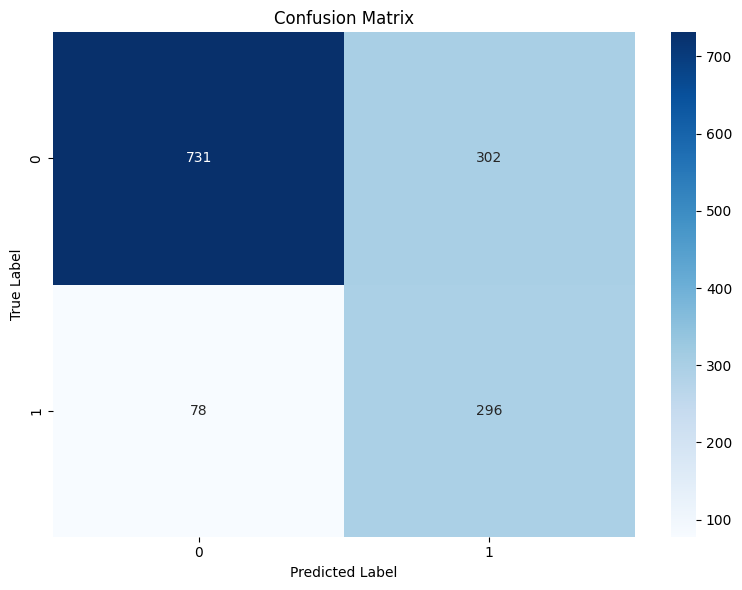

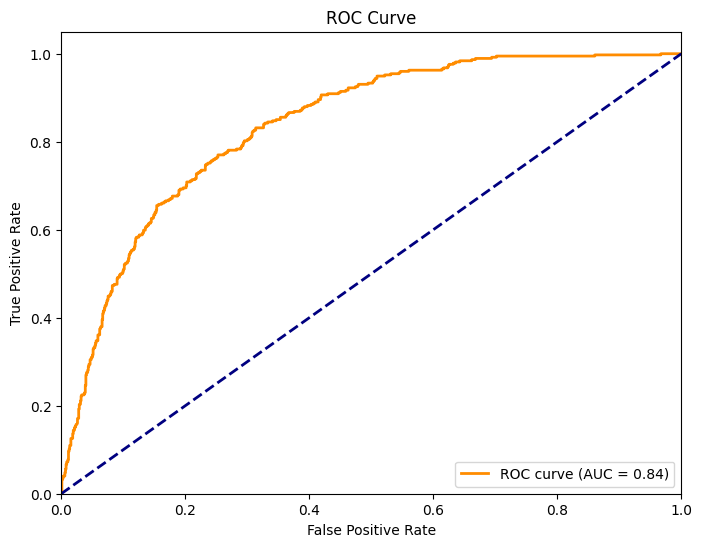

Feature names and coefficients truncated to match length: 59


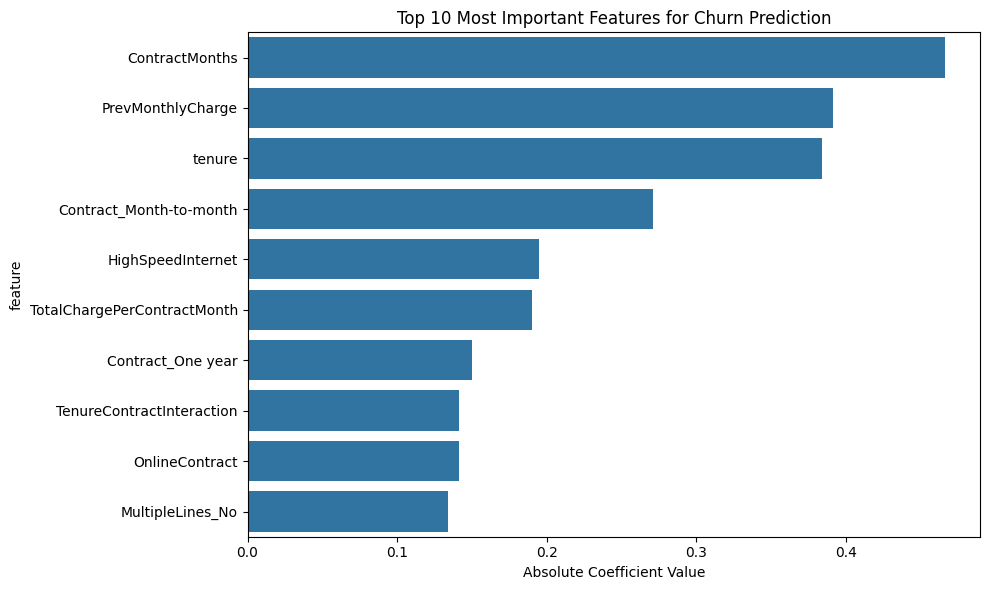

Top 10 most important features:                         feature  importance
11               ContractMonths    0.466225
16            PrevMonthlyCharge    0.391425
1                        tenure    0.383884
50      Contract_Month-to-month    0.270890
10            HighSpeedInternet    0.194609
13  TotalChargePerContractMonth    0.190229
51            Contract_One year    0.149717
12    TenureContractInteraction    0.141262
14               OnlineContract    0.141058
26             MultipleLines_No    0.134221


In [12]:
# Load the data set
X, y = churn_data_load()

# Split the data set into train/test sets and also get access to
# the transformer
X_train, X_test, y_train, y_test, pre_prcsr = data_prep(X, y)

# Fit the pre_prcsr
pre_prcsr.fit(X_train)

# Train the model
#model = train_model(X_train, y_train, pre_prcsr)
model = train_model_hyp_prmtr_tuning(X_train, y_train, pre_prcsr)

# Evaluate the model
final_model = evaluate_model(model, X_test, y_test)

# Retrieve the top 10 important features
imp_ftr_df = feature_importance(final_model, X_train)
print (f'Top 10 most important features: {imp_ftr_df.head(10)}')